### 0. Introduction

The main goal of this notebook is to explore different classification methods (decision trees, random forests, logistic regressions, K nearest neighbors and support vector machines) to try to accurately predict whether a given mushroom is edible or poisonous depending on the mushroom's features (cap shape, color, gill size, etc.).

For this analysis I use the 'mushrooms.csv' file, which can be found at https://www.kaggle.com/datasets/uciml/mushroom-classification/.

I will use pandas and numpy libraries for data processing, matplotlib and seaborn for visualisation, and sklearn for classification:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

mushroom_data = pd.read_csv('mushrooms.csv')
mushroom_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### 1. Initial exploratory analysis

We have 8124 rows or entries, and 23 columns all of which of "object" type, so categorical, and none of them have any null values:

In [2]:
mushroom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

It looks like the categories of each column are all represented by a single character. 

The category with the most unique classes is 'gill-color', with 12. On the other hand, the category with the least unique classes is 'veil-type', with only 1. Since this column has the same value for each instance, we can discard it from the analysis.

In [3]:
mushroom_data.describe().T

,count,unique,top,freq
class,8124,2,e,4208
cap-shape,8124,6,x,3656
cap-surface,8124,4,y,3244
cap-color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
gill-color,8124,12,b,1728


As discussed, we discard the 'veil-type' feature. Now 22 columns remain in the dataset (1 class to predict and 21 predictor features):

In [4]:
mushroom_data.drop(columns=['veil-type'], inplace=True)
mushroom_data.shape

(8124, 22)

The column 'class', which contains the variable to predict, can adopt two values: 'p' (poisonous) or 'e' (edible). This is a quite balanced dataset, as 51.8% of the instances are edible and 48.2% of them are poisonous:

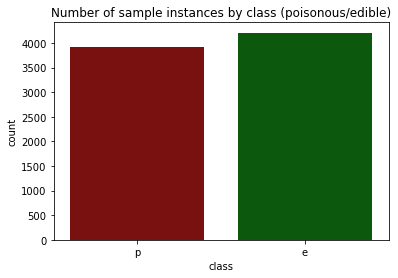

e    0.517971
p    0.482029
Name: class, dtype: float64


In [5]:
sns.countplot(x='class', data=mushroom_data, palette=['darkred', 'darkgreen'])
plt.title('Number of sample instances by class (poisonous/edible)')
plt.show()
print(mushroom_data['class'].value_counts(normalize=True))

For a visual analysis, we create count plots of all the other features in the dataset. After doing so, we see that the features 'gill-attachment' and 'veil-color' do not present much variance, as they both have a unique class which takes more than 97% of the instances. This could have already be seen previously in the results of the describe method. For now we will keep these features in the dataset.

Below, the count plots of these 2 features, together with 'gill-color' (a more evenly distributed feature for comparison) are shown: 

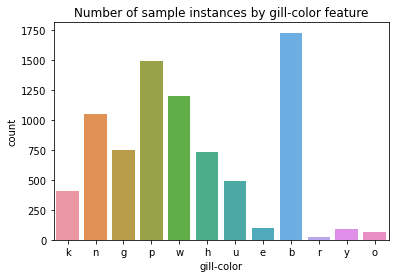

b    0.212703
p    0.183653
w    0.147957
n    0.129000
g    0.092565
h    0.090103
u    0.060561
k    0.050222
e    0.011817
y    0.010586
o    0.007878
r    0.002954
Name: gill-color, dtype: float64 




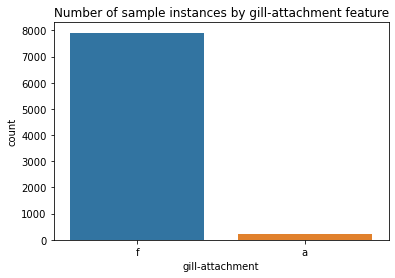

f    0.974151
a    0.025849
Name: gill-attachment, dtype: float64 




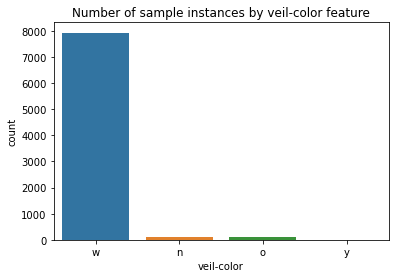

w    0.975382
n    0.011817
o    0.011817
y    0.000985
Name: veil-color, dtype: float64 




In [6]:
for c in ['gill-color', 'gill-attachment', 'veil-color']:
    sns.countplot(x=c, data=mushroom_data)
    plt.title('Number of sample instances by {} feature'.format(c))
    plt.show()
    print(mushroom_data[c].value_counts(normalize=True), '\n\n')

### 2. Encode categorical variables to numbers

For the coming numerical analyses, we will need to convert the categorical variables (all of them in this case) to numerical values.

While doing so, we save the encode and decode dictionaries in case we need to convert back and/or forth later:

In [7]:
from sklearn.preprocessing import LabelEncoder
encoded_mushroom_data = pd.DataFrame()

encode_dicts = {}
decode_dicts = {}

for col in mushroom_data.columns:
    le=LabelEncoder()
    encoded_mushroom_data[col] = le.fit_transform(mushroom_data[col])
    encode_dicts[col] = {c: i for i, c in enumerate(le.classes_)}
    decode_dicts[col] = {i: c for i, c in enumerate(le.classes_)}

print(encode_dicts)

{'class': {'e': 0, 'p': 1}, 'cap-shape': {'b': 0, 'c': 1, 'f': 2, 'k': 3, 's': 4, 'x': 5}, 'cap-surface': {'f': 0, 'g': 1, 's': 2, 'y': 3}, 'cap-color': {'b': 0, 'c': 1, 'e': 2, 'g': 3, 'n': 4, 'p': 5, 'r': 6, 'u': 7, 'w': 8, 'y': 9}, 'bruises': {'f': 0, 't': 1}, 'odor': {'a': 0, 'c': 1, 'f': 2, 'l': 3, 'm': 4, 'n': 5, 'p': 6, 's': 7, 'y': 8}, 'gill-attachment': {'a': 0, 'f': 1}, 'gill-spacing': {'c': 0, 'w': 1}, 'gill-size': {'b': 0, 'n': 1}, 'gill-color': {'b': 0, 'e': 1, 'g': 2, 'h': 3, 'k': 4, 'n': 5, 'o': 6, 'p': 7, 'r': 8, 'u': 9, 'w': 10, 'y': 11}, 'stalk-shape': {'e': 0, 't': 1}, 'stalk-root': {'?': 0, 'b': 1, 'c': 2, 'e': 3, 'r': 4}, 'stalk-surface-above-ring': {'f': 0, 'k': 1, 's': 2, 'y': 3}, 'stalk-surface-below-ring': {'f': 0, 'k': 1, 's': 2, 'y': 3}, 'stalk-color-above-ring': {'b': 0, 'c': 1, 'e': 2, 'g': 3, 'n': 4, 'o': 5, 'p': 6, 'w': 7, 'y': 8}, 'stalk-color-below-ring': {'b': 0, 'c': 1, 'e': 2, 'g': 3, 'n': 4, 'o': 5, 'p': 6, 'w': 7, 'y': 8}, 'veil-color': {'n': 0, 'o

In [8]:
encoded_mushroom_data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


### 3. Correlation matrix

This is arguably part of the initial exploratory analysis, but needs to be done after the encoding process.

We calculate an R squared value by calculating and squaring pearson coefficient for each combination of features, obtaining a heatmap that shows cells representing a high correlation in white, and cells representing no or low correlation in black.

Here, both the correlation between each pair of features, and the correlation between each feature and the class to predict are interesting:

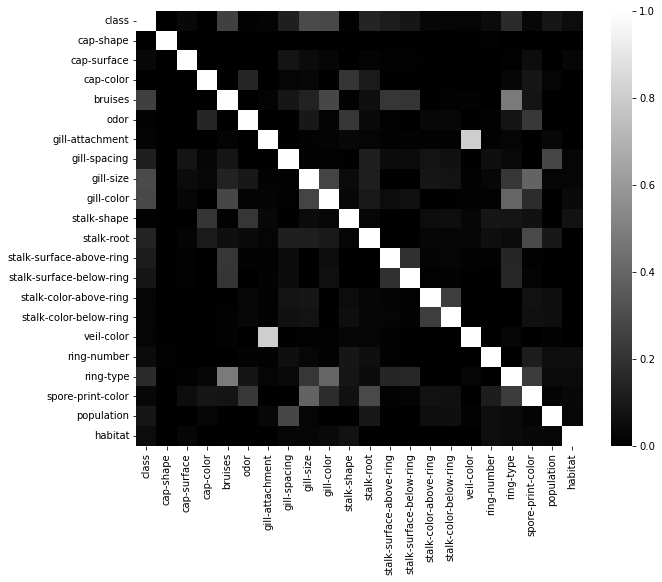

class                       1.000000
gill-size                   0.291626
gill-color                  0.281500
bruises                     0.251533
ring-type                   0.169556
stalk-root                  0.143915
gill-spacing                0.121373
stalk-surface-above-ring    0.111952
stalk-surface-below-ring    0.089282
population                  0.089213
habitat                     0.047167
ring-number                 0.045953
cap-surface                 0.031843
spore-print-color           0.029571
stalk-color-above-ring      0.023717
stalk-color-below-ring      0.021530
veil-color                  0.021066
gill-attachment             0.016693
stalk-shape                 0.010408
odor                        0.008752
cap-shape                   0.002804
cap-color                   0.000985
Name: class, dtype: float64


In [9]:
plt.figure(figsize=(10,8))
r2_matrix = encoded_mushroom_data.corr(method='pearson').applymap(lambda x: x**2)
sns.heatmap(r2_matrix, vmin=0, vmax=1, cmap='binary_r')
plt.show()
r2_class = r2_matrix['class'].sort_values(ascending=False)
print(r2_class)

#### 3.1. Class <> feature correlation

At this point, and based on these R squared values, we could discard those features that have a low correlation with the class to predict (low R squared).

Nevertheless, by doing this we could be losing some information. Even if the feature is not directly correlated with the class to predict, it might hold some useful information for the prediction.

So no features are discarded at this stage:

In [10]:
min_r2 = 0

feats_to_discard = list(r2_class[r2_class < min_r2].keys())
print('Discarded features:', feats_to_discard)

encoded_mushroom_data.drop(columns=feats_to_discard, inplace=True)

Discarded features: []


#### 3.2. Feature <> feature correlation: 'bruises' and 'ring-type'

The correlation between 'bruises' and 'ring-type' seems strong in the correlation matrix. If these features are highly correlated and no information is gained from considering both, one of them might be discarded. Let's count the number of samples for each combination of 'bruises' and 'ring-type' values:

In [11]:
count_table = encoded_mushroom_data.groupby(['bruises','ring-type']).size().reset_index()
cross_table = pd.pivot_table(count_table, index='bruises', columns='ring-type', values=0, fill_value=0)
cross_table

ring-type,0,1,2,3,4
bruises,,,,,
0,2584,48,1296,36,784
1,192,0,0,0,3184


By looking at the table above, we find that:
- when 'ring-type' feature adopts value 0, 'bruises' mostly adopts value 0.
- when 'ring-type' feature adopts values 1, 2 or 3, 'bruises' feature always adopts value 1 -> no information gain.
- when 'ring-type' feature adopts value 4, 'bruises' mostly adopts value 1.

We could just discard the 'bruises' column, but first we check if we would be losing useful data:
1. Is there any difference in the class to predict when 'ring-type' feature adopts value 0 and 'bruises' adopts value 0 from when 'ring-type' feature adopts value 0 and 'bruises' adopts value 1?
2. Is there any difference in the class to predict when 'ring-type' feature adopts value 4 and 'bruises' adopts value 0 from when 'ring-type' feature adopts value 4 and 'bruises' adopts value 1?

In [12]:
cross_table_class_count = encoded_mushroom_data.groupby(['bruises','ring-type', 'class']).size().reset_index()
cross_table_class_count.rename(columns={0: 'sample count'}, inplace=True)
cross_table_class_count

,bruises,ring-type,class,sample count
0,0,0,0,816
1,0,0,1,1768
2,0,1,0,48
3,0,2,1,1296
4,0,3,1,36
5,0,4,0,592
6,0,4,1,192
7,1,0,0,192
8,1,4,0,2560
9,1,4,1,624


By looking at the table above, we can find the answer to the previous questions:

1. When 'ring-type' feature adopts value 0 and 'bruises' adopts value 0, the poisonous percentage is 1768/(816+1768) = 68.4%. On the other hand, when 'ring-type' feature adopts value 0 and 'bruises' adopts value 1 the poisonous percentage is 0/(192+0) = 0%. **There is a big difference here**
2. When 'ring-type' feature adopts value 4 and 'bruises' adopts value 0, the poisonous percentage is 192/(592+192) = 24.5%. On the other hand, when 'ring-type' feature adopts value 4 and 'bruises' adopts value 1 the poisonous percentage is 624/(2560+624) = 19.6%.

If we removed the 'bruises' column, we would probably lose important information for classification! We can see that 68.4% of mushrooms for which ring-type=0 and bruises=0 are poisonous, whereas all the mushrooms with ring-type=0 and bruises=1 are edible! We would not be able to see that with only 'ring-type'.

We keep both features in the data for now. We could also encode these 2 columns into 1, as some values as redundant (i.e. when ring-type equals 2, 3 or 4, bruises always equals 1).

#### 3.3. Feature <> feature correlation: 'veil-color' and 'gill-attachment'

The correlation between 'bruises' and 'ring-type' seems strong in the correlation matrix, and these are precisely the variables that we had previously detected that had the least variance. Let's count the number of samples for each combination of 'bruises' and 'ring-type' values:

In [13]:
count_table = encoded_mushroom_data.groupby(['veil-color','gill-attachment']).size().reset_index()
cross_table = pd.pivot_table(count_table, index='veil-color', columns='gill-attachment', values=0, fill_value=0)
cross_table

gill-attachment,0,1
veil-color,,
0,96,0
1,96,0
2,18,7906
3,0,8


By looking at the table above, we find that:
- when 'veil-color' feature adopts values 0 or 1, 'gill-attachment' always adopts value 0 -> no information gain.
- when 'veil-color' feature adopts value 2, 'gill-attachment' feature mostly adopts value 1 (7906 vs 18) -> practically no information gain.
- when 'veil-color' feature adopts value 3, 'gill-attachment' always adopts value 1  -> no information gain.

Plus, as seen in the exploratory analysis, the 'gill-attachment' has almost no variance, so we finally decide to discard this column. 20 predictor features remain:

In [14]:
feats_to_discard = ['gill-attachment']
encoded_mushroom_data.drop(columns=feats_to_discard, inplace=True)
encoded_mushroom_data.shape

(8124, 21)

### 4. Standard scaling of features

Before performing PCA and some classification methods such as KNN, we need to scale each predictor feature so that all of them have the same mean (0) and variance (1).

We store the scaled predictor features in the N-dimensional array X, where N is the number of predictor features; while we store the variable to predict ('class') in the 1-dimensional array y.

In [15]:
X = encoded_mushroom_data.drop(columns=['class'])
y = np.array(encoded_mushroom_data['class'])

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

print(scaled_X)
print('\n')
print(y)

[[ 1.02971224  0.14012794 -0.19824983 ... -0.67019486 -0.5143892
   2.03002809]
 [ 1.02971224  0.14012794  1.76587407 ... -0.2504706  -1.31310821
  -0.29572966]
 [-2.08704716  0.14012794  1.37304929 ... -0.2504706  -1.31310821
   0.86714922]
 ...
 [-0.8403434   0.14012794 -0.19824983 ... -1.50964337 -2.11182722
   0.28570978]
 [-0.21699152  0.95327039 -0.19824983 ...  1.42842641  0.28432981
   0.28570978]
 [ 1.02971224  0.14012794 -0.19824983 ...  0.16925365 -2.11182722
   0.28570978]]


[1 0 0 ... 0 1 0]


### 5. One-hot encoding

In many cases, we will gain a lot from splitting each categorical feature (0-N values) to N different 0-1 columns.

This is because the categorical data is now presented as numbers (e.g. 1, 2, 3, 4), but we will not really want classification algorithms to treat them as such, since that would mean that "1" value is much closer to "2" than it is to "4", and the classifiers will try to group "1" and "2" together, but it would be harder for them to group "1" and "4".

As an example, in a categorical variable maybe "1" just means "blue", "2" means "red" and "4" means "white", in which case it would not make sense algorithms to consider the data numerically.

In [16]:
onehot_encoded_X = pd.get_dummies(X, columns=X.columns)
onehot_encoded_X.head()

,cap-shape_0,cap-shape_1,cap-shape_2,cap-shape_3,cap-shape_4,cap-shape_5,cap-surface_0,cap-surface_1,cap-surface_2,cap-surface_3,...,population_3,population_4,population_5,habitat_0,habitat_1,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


### 6. Dimensionality reduction: PCA

PCA allows for the expression of the features in a lower dimension, while accounting to as much part of the variance as possible. This allows for computational processing time improvement (which in this case is not so relevant, as it is a relatively small dataset), but also it can improve performance of classification methods by reducing the number of features.

Firstly, we will generate a scree plot to check how much of the variance is explained by the n principal components:

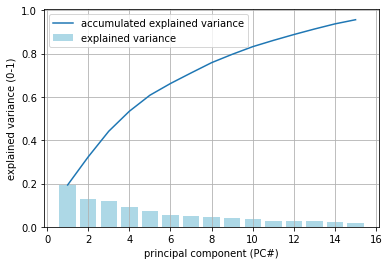

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
pca.fit(scaled_X)
pc_ratios = pca.explained_variance_ratio_

pc_nums = list(range(1, len(pc_ratios) + 1))
plt.bar(height=pc_ratios, x=pc_nums, color='lightblue')
acc = [ratio + sum(pc_ratios[:i]) for i, ratio in enumerate(pc_ratios)]
plt.plot(pc_nums, acc)
plt.grid()
plt.legend(['accumulated explained variance','explained variance'])
plt.xlabel('principal component (PC#)')
plt.ylabel('explained variance (0-1)')
plt.show()

Visualise PCA reduction in 2D:

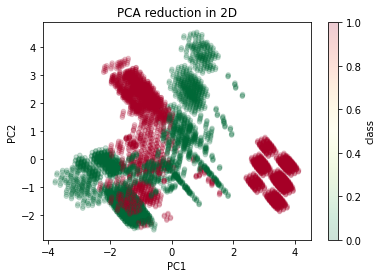

Total explained variance:  0.323


In [18]:
pca = PCA(n_components=2)
pca.fit(scaled_X)

reduced_X = pca.transform(scaled_X)

reduced_data = pd.DataFrame(data=reduced_X, columns=['PC1', 'PC2'])
reduced_data['class'] = y

reduced_data.plot.scatter(x='PC1', y='PC2', c='class', colormap='RdYlGn_r', alpha=0.2, sharex=False)
plt.title('PCA reduction in 2D')
plt.show()

print('Total explained variance: ', round(sum(pca.explained_variance_ratio_), 3))

Visualise PCA reduction in 3D:

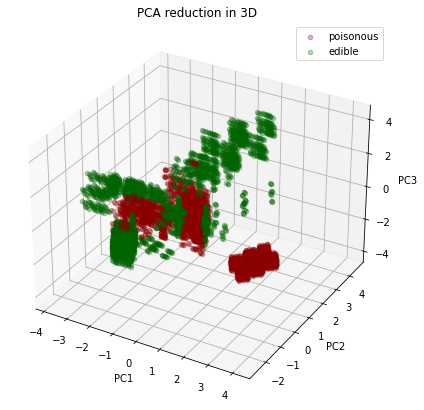

Total explained variance:  0.442


In [19]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(scaled_X)

reduced_X = pca.transform(scaled_X)

reduced_data = pd.DataFrame(data=reduced_X, columns=['PC1', 'PC2', 'PC3'])
reduced_data['class'] = y

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')

for i, class_i in enumerate(y):
    xi, yi, zi = reduced_data['PC1'][i], reduced_data['PC2'][i], reduced_data['PC3'][i]
    
    if class_i == 1:  # poisonous
        c = 'darkred'
    else:  # edible
        c = 'darkgreen'
    
    ax.scatter(xi, yi, zi, c=c, alpha=0.3)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA reduction in 3D')
ax.legend(['poisonous',  'edible'])
plt.show()

print('Total explained variance: ', round(sum(pca.explained_variance_ratio_), 3))

Even when reducing only to 3 dimensions, which only accounts for 44.2% of the variation, we see some clear limits between many samples classified as edible and others classified as poisonous. This means that the data is probably relatively easily separable with a classification algorithm.

### 7. Classification algorithms

#### 7.0. Common imports

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#### 7.1. Decision tree

Firstly, we try to build a decision tree without PCA. Applying PCA dimensionality reduction would affect the explainability of our model, since we would not be able to clearly understand the conditions of the decision nodes of our tree. If the results are good enough without applying PCA, we will not need to apply it.

Feature standard scaling is not needed for decision trees, so we use the data before scaling. Again, not scaling the variables gives us a better understanding of the conditions that our decision tree will contain.

First, we build several decision trees for different values of max_depth (maximum tree depth, or maximum number of tree "levels"). By analysing the results for different max_depth values, we can choose the optimal value:

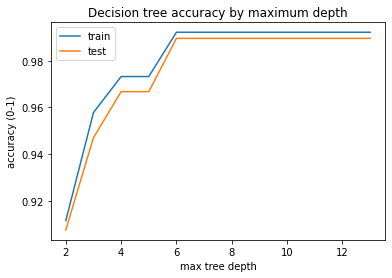

In [21]:
from sklearn.tree import DecisionTreeClassifier

train_accuracies = {}
test_accuracies = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)
    
for max_depth in range(2, 14):
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=20, 
                                 random_state=42, min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    test_accuracies[max_depth] = accuracy_score(y_test, y_test_pred)
    train_accuracies[max_depth] = accuracy_score(y_train, y_train_pred)


plt.plot(train_accuracies.keys(), train_accuracies.values())
plt.plot(test_accuracies.keys(), test_accuracies.values())
plt.title('Decision tree accuracy by maximum depth')
plt.xlabel('max tree depth')
plt.ylabel('accuracy (0-1)')
plt.legend(['train', 'test'])
plt.show()

The decision tree does not seem to get any better by increasing the maximum tree depth more than 6. This may partially be due to the fact that we have set 20 minimum samples per leaf, thus applying an indirect limit to the maximum depth.

In any case, we choose a maximum depth of 6 for our final decision tree, which we build, train, test and plot below:

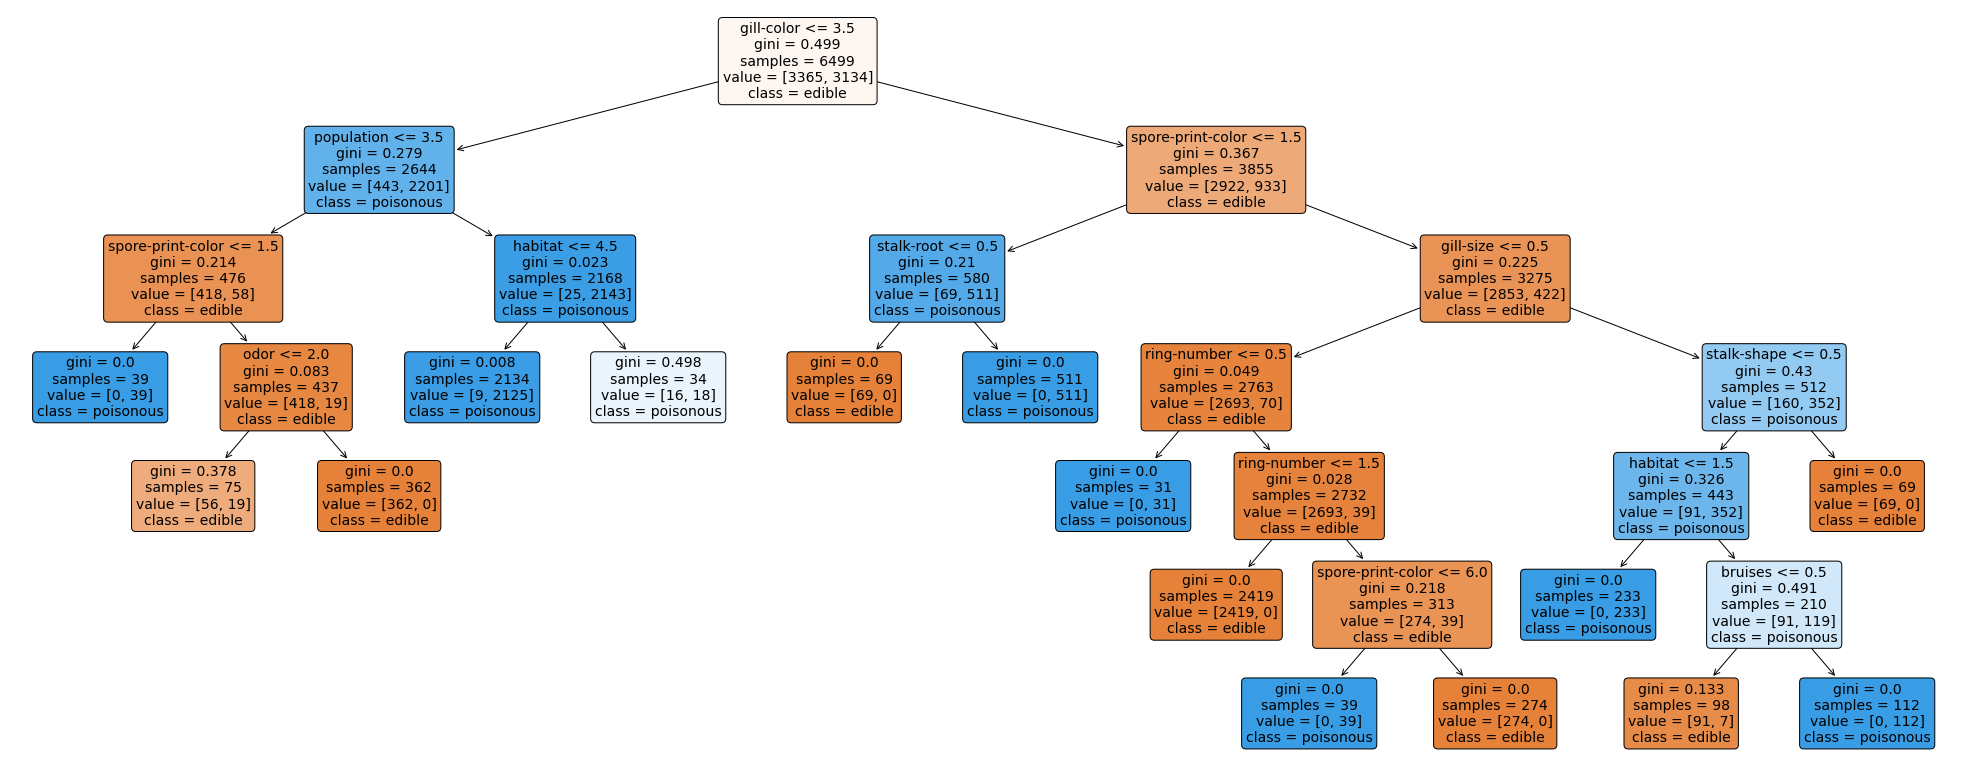

Test accuracy: 0.9895


,Predicted edibles,Predicted poisonous
Actual edibles,832,11
Actual poisonous,6,776


In [22]:
max_depth = 6
clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=20, 
                             random_state=42, min_impurity_decrease=0.001)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)

from sklearn.tree import plot_tree
plt.figure(figsize=(35,14))
plot_tree(clf, 
          feature_names=X.columns, 
          class_names=['edible', 'poisonous'], 
          fontsize=14, filled=True, rounded=True)
plt.show()

print('Test accuracy: {}'.format(round(test_accuracy, 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

These results are extremely good for a classification problem. The test accuracy is 0.9895, very close to 1. The false positives and false negatives are relatively low when checking the confusion matrix.

Nevertheless, when building a model that tells somebody if it is safe to eat a mushroom or not, 99% of accuracy might not be enough. In the confusion matrix we can see how, from the 838 mushrooms that the decision tree predicts are edible, 6 of them are actually poisonous. This corresponds to a 6/838 = 0.7% chance that a mushroom that is classified as edible by the model is actually poisonous. Would you take this risk?

We would prefer the model to only classify a mushroom as edible when it is completely sure that it corresponds to an edible one, and just tag the rest as potentially poisonous. In order to do so, we will make use of the DecisionTreeClassifier class' method "predict_proba()". This method obtains not just the predicted classes by the decision tree (int 0/1), but the predicted probabilities (float from 0-1). These are calculated by looking at the proportion of instances of each class that are in the leaf node at which the test instance ends up:

In [23]:
y_train_prob = [i[1] for i in clf.predict_proba(X_train)]
y_train_prob[:10]

[0.9957825679475164,
 0.9957825679475164,
 0.9957825679475164,
 0.0,
 0.0,
 0.9957825679475164,
 0.0,
 0.0,
 1.0,
 1.0]

Thus, if an instance that we aim to classify falls to a leaf node in which all the instances from the train data are poisonous, the obtained "poisonous probability" will be 1.0. On the other hand, if all the instances in the leaf node are edible, the probability will be 0.0. If we found half of each class, the probability would be 0.5, and so on. It is easy to see that, by classifying as edible only those instances that fall in a leaf node for which poisonous probability is exactly 0.0, then we will never classify a poisonous mushroom from the train data as edible. 

Let's measure how many of the instances of the train data fall into a node that only contains edible mushrooms:

In [24]:
actual_edibles = len([y for y in y_train if y == 0])
edibles_for_sure = len([p for p in y_train_prob if p == 0])

print('Edibles for sure: {}/{}   ({}% of samples)'.format(edibles_for_sure, actual_edibles,
                                                          round(100 * edibles_for_sure / actual_edibles, 1)))

Edibles for sure: 3193/3365   (94.9% of samples)


This is interesting, as most of the edible samples (94.9%) are contained in nodes in which all of the samples are edible.

This means that we could make a model that successfully classifies almost 95% of all edible mushrooms as edible, and tags the rest as poisonous. We would be losing 5% of edible mushrooms, which we are classifying as poisonous, but this error is much less grave than classifying a poisonous mushroom as edible.

But all this looks a little bit like cheating, as we are only working with the train data. The key question now would be: how well would this model behave with the test data? Let's see:

In [25]:
y_test_prob = [i[1] for i in clf.predict_proba(X_test)]
y_test_pred = [0 if i == 0 else 1 for i in y_test_prob]
print('Test accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Test accuracy: 0.9705


,Predicted edibles,Predicted poisonous
Actual edibles,795,48
Actual poisonous,0,782


By comparing to the original decision tree, we are losing a bit of accuracy (98 to 97%), but we are actually getting exactly what we wanted. In the confusion matrix we see that none of the mushrooms that we predict as edible are actually poisonous.

Now, we will apply cross validation to see if these results happen by chance/overfitting, and to have a better grasp of how reliable this model would be with new data. For cross validation, we split into train/test data several times ("n_iters") and we build, train and test the resulting decision tree for each of these splits. 

Of course, these decision trees follow the rule that we had set before: instead of getting the "normal" prediction, we reach the probability values for each new instance, and if the probability value is exactly 0.0 we classify it as edible. Otherwise, we classify it as poisonous.

We build 50 decision trees for different train/test data splits:

In [26]:
n_iters = 50

for rs in range(n_iters):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=rs)
    
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=20,
                                 random_state=42, min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    
    y_test_prob = [ps[1] for ps in clf.predict_proba(X_test)]
    y_test_pred = [0 if p == 0 else 1 for p in y_test_prob]
    
    test_accuracies[i] = accuracy_score(y_test, y_test_pred)
    print('Train/test split random state: {}'.format(rs))
    print('Accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
    print(confusion_matrix(y_test, y_test_pred), '\n')

Train/test split random state: 0
Accuracy: 0.5569
[[132 720]
 [  0 773]] 

Train/test split random state: 1
Accuracy: 0.5625
[[109 711]
 [  0 805]] 

Train/test split random state: 2
Accuracy: 0.5446
[[120 740]
 [  0 765]] 

Train/test split random state: 3
Accuracy: 0.5643
[[129 708]
 [  0 788]] 

Train/test split random state: 4
Accuracy: 0.5705
[[147 698]
 [  0 780]] 

Train/test split random state: 5
Accuracy: 0.5723
[[132 695]
 [  0 798]] 

Train/test split random state: 6
Accuracy: 0.5625
[[137 711]
 [  0 777]] 

Train/test split random state: 7
Accuracy: 0.5698
[[141 699]
 [  0 785]] 

Train/test split random state: 8
Accuracy: 0.5483
[[136 734]
 [  0 755]] 

Train/test split random state: 9
Accuracy: 0.5489
[[142 733]
 [  0 750]] 

Train/test split random state: 10
Accuracy: 0.5508
[[131 730]
 [  0 764]] 

Train/test split random state: 11
Accuracy: 0.9692
[[809  50]
 [  0 766]] 

Train/test split random state: 12
Accuracy: 0.5772
[[126 687]
 [  0 812]] 

Train/test split rando

The results are quite poor. Some train/test data splits such as the ones produced by random states 11, 13, 23, 29 or 42 are working quite well, but others are not working well at all, with accuracies even under 50% in some cases.

At least with all models we can be sure that the mushrooms classified as edible are in fact edible and not poisonous, but some of them only classify as edible even less than 10-20% of all the actual edible ones.

Thus, our decision tree model presents a high variance and it is often not accurate. Probably the 0.0 limit on the probability is too harsh for some decision trees, which might not have many leaf nodes with a 'perfect' class split as the example that we had before. Nevertheless, if we tweak this limit and raise it e.g. to 0.01, then we start getting some poisonous mushrooms classified as edible in some trees.

Maybe a random forest made of several decision trees might offer better results.

#### 7.2. Random forest

A random forest is an ensemble method consisting on several decision trees. For a new instance, the probability of the whole random forest is the average of the probabilities assigned by each decision tree.

Let's analyse the accuracy achieved by some random forest depending on the number of estimators (number of decision trees that it is built of):

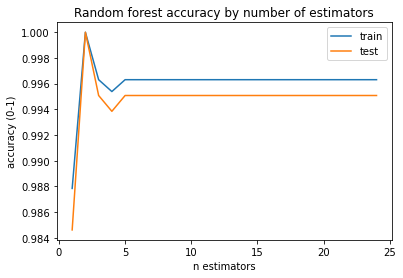

In [27]:
from sklearn.ensemble import RandomForestRegressor

train_accuracies = {}
test_accuracies = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
    
for n_estimators in range(1, 25):
    clf = RandomForestRegressor(n_estimators=n_estimators, 
                                max_depth=6,
                                max_features='auto',
                                oob_score= False,
                                n_jobs=-1,
                                random_state=1)

    clf.fit(X_train, y_train)

    y_train_prob = clf.predict(X_train)
    y_train_pred = np.array([round(y_probability) for y_probability in y_train_prob])
    y_test_prob = clf.predict(X_test)
    y_test_pred = np.array([round(y_probability) for y_probability in y_test_prob])
    
    test_accuracies[n_estimators] = accuracy_score(y_test, y_test_pred)
    train_accuracies[n_estimators] = accuracy_score(y_train, y_train_pred)

plt.plot(train_accuracies.keys(), train_accuracies.values())
plt.plot(test_accuracies.keys(), test_accuracies.values())
plt.title('Random forest accuracy by number of estimators')
plt.xlabel('n estimators')
plt.ylabel('accuracy (0-1)')
plt.legend(['train', 'test'])
plt.show()

After playing with different numbers of "random_state" variable for the test/train data split function, we see that only with 2 or 3 decision trees, the accuracy of a single one is generally sensibly improved.

Generally, the higher the number of estimators, the higher the accuracy, both for the train and test data. We will start with a random forest with 20 estimators, and obtain its confusion matrix below:

In [28]:
clf = RandomForestRegressor(n_estimators=20, 
                            max_depth=6,
                            max_features='auto',
                            oob_score= False,
                            n_jobs=-1,
                            random_state=1)

clf.fit(X_train, y_train)

y_test_prob = clf.predict(X_test)
y_test_pred = np.array([round(y_probability) for y_probability in y_test_prob])

print('Test accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Test accuracy: 0.9951


,Predicted edibles,Predicted poisonous
Actual edibles,820,0
Actual poisonous,8,797


The accuracy is very high, but again as it was the case with decision trees, we would like the number of actual poisonous samples that we predict as edible to be 0, even if that means sacrificing a bit of accuracy.

In order to do so, we could set the same condition as in the previous decision trees, either the poisonous probability is exactly 0.0 or we classify the sample as poisonous. The results can be seen below:

In [29]:
y_test_pred = [0 if p == 0 else 1 for p in y_test_prob]

print('Test accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Test accuracy: 0.5705


,Predicted edibles,Predicted poisonous
Actual edibles,122,698
Actual poisonous,0,805


The results are quite bad. Since this is a random forest made of several different decision trees, the final probability is an average of the probabilities of each decision tree, thus if a tree gives an instance a probability higher than 0.0, then we already 'lose it' and will never classify it as edible.

Probably a better estimate would consist in applying a softer threshold, maybe at p=0.05 or 0=0.1. 

If we set a probability threshold of 0.1 for this random forest, the results we get are just what we were aiming for:

In [30]:
y_test_pred = [0 if p <= 0.1 else 1 for p in y_test_prob]

accuracy_score(y_test, y_test_pred)

print('Test accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Test accuracy: 0.9945


,Predicted edibles,Predicted poisonous
Actual edibles,811,9
Actual poisonous,0,805


Let's see which probability threshold we can pick that works well for all random forests trained with different sets of data. We want the classificator accuracies to be as high as possible, while the "false edibles" count shall remain 0 (i.e. position 1,2 of the confusion matrices).

We find that p = 0.04 results in a nice trade-off, since even when creating 200 different random forests with different random train/test data splits, none of them predict any false edibles, and the forest with the worst accuracy still has more than 0.93:

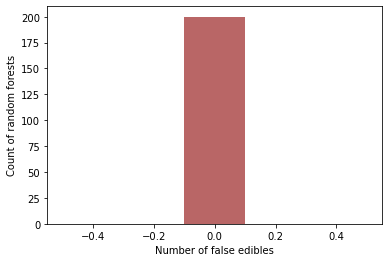

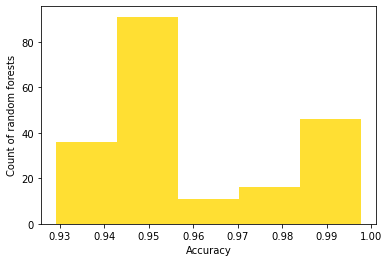

In [31]:
n_iters = 200
p_threshold = 0.04

test_accuracies, false_edibles = [], []

for rs in range(n_iters):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=rs)
    
    clf = RandomForestRegressor(n_estimators=6, 
                                max_depth=6,
                                max_features='auto',
                                oob_score= False,
                                n_jobs=-1,
                                random_state=42)
    
    clf.fit(X_train, y_train)
    
    y_test_prob = clf.predict(X_test)
    y_test_pred = [0 if p <= p_threshold else 1 for p in y_test_prob]
    
    accuracy = accuracy_score(y_test, y_test_pred)
    cf_matrix = confusion_matrix(y_test, y_test_pred)
    
    test_accuracies.append(accuracy)
    false_edibles.append(cf_matrix[1][0])
    # print('Train/test split random state: {}'.format(rs))
    # print('Accuracy: {}'.format(round(accuracy, 4)))
    # print(cf_matrix, '\n')

plt.hist(false_edibles, bins=5, color='darkred', alpha=0.6)
plt.xlabel('Number of false edibles')
plt.ylabel('Count of random forests')
plt.show()

plt.hist(test_accuracies, bins=5, color='gold', alpha=0.8)
plt.xlabel('Accuracy')
plt.ylabel('Count of random forests')
plt.show()

So we choose one of these random forests with p_threshold = 0.04 as our final classifier. 

The interesting part of this classifier is that its edible mushroom predictions are very reliable: the precision of the edible class is 100%. This means that all of the mushrooms that it classifies as edible are, in fact, edible. The downside is that it only finds around 90% of the edible mushrooms, i.e. it classifies around 10% of the actual edible mushrooms as poisonous:

In [32]:
p_threshold = 0.04

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

clf = RandomForestRegressor(n_estimators=6, 
                            max_depth=6,
                            max_features='auto',
                            oob_score= False,
                            n_jobs=-1,
                            random_state=42)

clf.fit(X_train, y_train)

y_test_prob = clf.predict(X_test)
y_test_pred = [0 if p <= p_threshold else 1 for p in y_test_prob]

accuracy = accuracy_score(y_test, y_test_pred)
cf_matrix = confusion_matrix(y_test, y_test_pred)

print('Test accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Test accuracy: 0.9526


,Predicted edibles,Predicted poisonous
Actual edibles,743,77
Actual poisonous,0,805


#### 7.3. K Nearest Neighbors

When K-Nearest Neighbors classifier (KNN) gets an instance to predict, it calculates the N-dimensional Euclidean distances from this new instance to all the train instances for which we know the class.

After calculating the distances, it finds the K closest instances to the new one (K nearest neighbors) and it finds the classes of those instances. It assigns to the new instance the class that is more frequent among the nearest neighbors.

K Nearest Neighbors algorithm also can work with probabilities. As an example, if K = 5 and we find that 3 of the closest neighbors to a new instance are of class 'A' and the other 2 are of class 'B', the model will assign the new instance a 0.6 probability of belonging to class 'A', and a 0.4 probability of belonging to class 'B'.

This method is what is called a lazy estimator. This means that the model is not actually trained, but all the processing (distances calculation) happens at the moment when we want to predict classes of new instances. Thus, we always need to have access to all the train data when running the predictions. This makes KNN computationally expensive.

As this classifier calculates distances bewteen instances, scaling the features is needed (we use "scaled_X").

We generate 100 different train/test data splits, and calculate the accuracy of the KNN algorithms for k=1 (considering only the class of the closest neighbor. In this case, since K=1, we cannot really play with probabilities, since p will always be either 0.0 or 1.0:

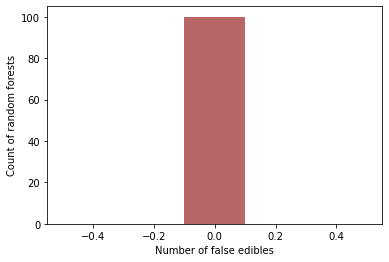

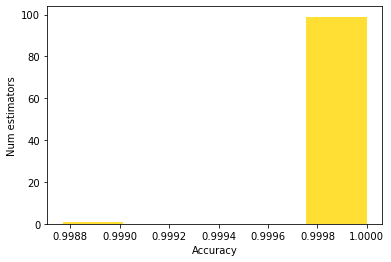

In [33]:
from sklearn.neighbors import KNeighborsClassifier

accuracies, false_edibles = [], []

for rs in range(100):
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                        test_size=0.2, 
                                                        random_state=rs)
    k = 1
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)

    # y_train_prob = [ps[1] for ps in clf.predict_proba(X_train)]
    # y_train_pred = [0 if p <= p_threshold else 1 for p in y_train_prob]

    # y_test_prob = [ps[1] for ps in clf.predict_proba(X_test)]
    # y_test_pred = [0 if p <= p_threshold else 1 for p in y_test_prob]
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    cf_matrix = confusion_matrix(y_test, y_test_pred)

    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    
    false_edibles.append(cf_matrix[0][1])
    accuracies.append(acc_test)

plt.hist(false_edibles, bins=5, color='darkred', alpha=0.6)
plt.xlabel('Number of false edibles')
plt.ylabel('Count of random forests')
plt.show()

plt.hist(accuracies, bins=5, color='gold', alpha=0.8)
plt.xlabel('Accuracy')
plt.ylabel('Num estimators')
plt.show()

Just by looking at the closest mushroom from the train data, the KNN classifier is able to achieve perfect accuracy (1.0) for almost every train/test data split (99/100).

We can just select a KNN model with K=1:

In [34]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
k = 1
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)

before_pred_dt = datetime.now()
y_test_pred = clf.predict(X_test)
after_pred_dt = datetime.now()

cf_matrix = confusion_matrix(y_test, y_test_pred)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Prediction time (seconds): {}'.format(round((after_pred_dt - before_pred_dt).total_seconds(), 5)))
print('Test accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Prediction time (seconds): 0.19162
Test accuracy: 1.0


,Predicted edibles,Predicted poisonous
Actual edibles,820,0
Actual poisonous,0,805


Since this classification method is relatively computationally expensive, let's try to make it a bit more efficient by reducing dimensionality with PCA.

We can see that for this particular KNN classifier (and for most), performing it with 9 principal components also results in 100% accuracy. Therefore, if we had to apply this solution to a huge set of data, it would be faster to first apply PCA:

In [35]:
pca = PCA(n_components=9)
pca.fit(scaled_X)
reduced_X = pca.transform(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
k = 1
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)

before_pred_dt = datetime.now()
y_test_pred = clf.predict(X_test)
after_pred_dt = datetime.now()

cf_matrix = confusion_matrix(y_test, y_test_pred)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Prediction time (seconds): {}'.format(round((after_pred_dt - before_pred_dt).total_seconds(), 5)))
print('Test accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Prediction time (seconds): 0.03651
Test accuracy: 1.0


,Predicted edibles,Predicted poisonous
Actual edibles,820,0
Actual poisonous,0,805


By changing n_components=3, we can see that even with only 3 dimensions, the model's accuracy is still quite high. This is compatible with the fact that, when we plotted the data in 3D (in section 5.), we already saw that it looked quite feasible  to differentiate the classes in this sub-space. 

In [36]:
pca = PCA(n_components=3)
pca.fit(scaled_X)
reduced_X = pca.transform(scaled_X)

X_train, X_test, y_train, y_test = train_test_split(reduced_X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
k = 1
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)

before_pred_dt = datetime.now()
y_test_pred = clf.predict(X_test)
after_pred_dt = datetime.now()

cf_matrix = confusion_matrix(y_test, y_test_pred)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Prediction time (seconds): {}'.format(round((after_pred_dt - before_pred_dt).total_seconds(), 5)))
print('Test accuracy: {}'.format(round(accuracy_score(y_test, y_test_pred), 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Prediction time (seconds): 0.03632
Test accuracy: 0.9908


,Predicted edibles,Predicted poisonous
Actual edibles,815,5
Actual poisonous,10,795


#### 7.4. Logistic regression

Binary logistic regression tries to fit a sigmoid curve that predicts the probability of each class value based on a set of feature values.

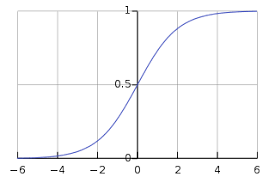

Here, we will need one-hot encoding, as our features are categorical. If we did not do this encoding, the logistic regression would assume that gill-size 2 is closer to gill-size 1 than to gill-size 0, but all these are just different classes.

We train and get the accuracy of 100 different logistic regressions based on 100 different train/test data splits:

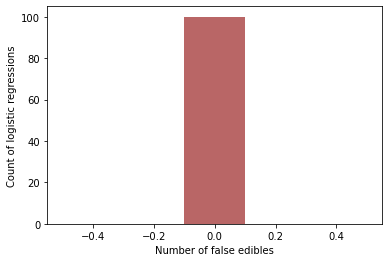

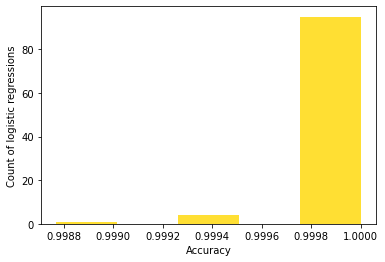

In [37]:
from sklearn.linear_model import LogisticRegression

test_accuracies, false_edibles = [], []

p_threshold = 0.2
for split_random_state in range(100):

    X_train, X_test, y_train, y_test = train_test_split(onehot_encoded_X, y, 
                                                        test_size=0.2, 
                                                        random_state=split_random_state)

    clf = LogisticRegression(random_state=42)

    clf.fit(X_train, y_train)

    y_train_prob = [ps[1] for ps in clf.predict_proba(X_train)]
    y_train_pred = [0 if p <= p_threshold else 1 for p in y_train_prob]

    y_test_prob = [ps[1] for ps in clf.predict_proba(X_test)]
    y_test_pred = [0 if p <= p_threshold else 1 for p in y_test_prob]

    cf_matrix = confusion_matrix(y_test, y_test_pred)

    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    test_accuracies.append(acc_test)
    false_edibles.append(cf_matrix[1][0])

plt.hist(false_edibles, bins=5, color='darkred', alpha=0.6)
plt.xlabel('Number of false edibles')
plt.ylabel('Count of logistic regressions')
plt.show()

plt.hist(test_accuracies, bins=5, color='gold', alpha=0.8)
plt.xlabel('Accuracy')
plt.ylabel('Count of logistic regressions')
plt.show()

The accuracy of these logistic regressions is extremely good! We can select one of these logistic regressions as our final model:

In [38]:
p_threshold = 0.2
split_random_state = 42

X_train, X_test, y_train, y_test = train_test_split(onehot_encoded_X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

clf = LogisticRegression(random_state=42)

clf.fit(X_train, y_train)

y_train_prob = [ps[1] for ps in clf.predict_proba(X_train)]
y_train_pred = [0 if p <= p_threshold else 1 for p in y_train_prob]

y_test_prob = [ps[1] for ps in clf.predict_proba(X_test)]
y_test_pred = [0 if p <= p_threshold else 1 for p in y_test_prob]

cf_matrix = confusion_matrix(y_test, y_test_pred)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: {}'.format(round(acc_train, 4)))
print('Test accuracy: {}'.format(round(acc_test, 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Train accuracy: 1.0
Test accuracy: 1.0


,Predicted edibles,Predicted poisonous
Actual edibles,820,0
Actual poisonous,0,805


#### 7.5. Naive Bayes

We will use categorical Naive Bayes classifier, which estimates independent probabilities of observing an instance of each feature value for each class, and then uses Bayes theorem to calculate compound probabilities.

This method assumes that all the features in a dataset are equally important, and that they are independent of each other and there is no correlation between features. This is hardly ever true in real life, but Naive Bayes usually works relatively well with big datasets with many features, and is very fast to compute.

By playing with "p_threshold" and "random_state", we can quickly see that this algorithm is not going to provide better results that the random forest or the logistic regression:

In [39]:
from sklearn.naive_bayes import CategoricalNB

p_threshold = 0.00005
split_random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=split_random_state)

clf = CategoricalNB()

clf.fit(X_train, y_train)

y_train_prob = [ps[1] for ps in clf.predict_proba(X_train)]
y_train_pred = [0 if p <= p_threshold else 1 for p in y_train_prob]

y_test_prob = [ps[1] for ps in clf.predict_proba(X_test)]
y_test_pred = [0 if p <= p_threshold else 1 for p in y_test_prob]

cf_matrix = confusion_matrix(y_test, y_test_pred)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: {}'.format(round(acc_train, 4)))
print('Test accuracy: {}'.format(round(acc_test, 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Train accuracy: 0.9369
Test accuracy: 0.9286


,Predicted edibles,Predicted poisonous
Actual edibles,728,115
Actual poisonous,1,781


#### 7.6. SVM

Support Vector Machines are a widely used tool used for classification problems. They aim to find the best hyperplane that splits the train data points in 2 groups with the most different classes, while maximising the margin to the support vectors.

But when SVM cannot find a good hyperplane in the existing number of dimensions, it can increase the dimensions with kernel functions in order to find hyperplanes in this new higher space. We will use the default 'rbf' (radial basis) kernel function

SVM, as was the case with logistic regression, and for the same reasons, will input the One-hot encoded categorical features.

In [40]:
from sklearn.svm import SVC

p_threshold = 0.1
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(onehot_encoded_X, y, 
                                                    test_size=0.2, 
                                                    random_state=random_state)

clf = SVC()
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_test_pred)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print('Train accuracy: {}'.format(round(acc_train, 4)))
print('Test accuracy: {}'.format(round(acc_test, 4)))
pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
             columns=['Predicted edibles','Predicted poisonous'], 
             index=['Actual edibles','Actual poisonous'])

Train accuracy: 1.0
Test accuracy: 1.0


,Predicted edibles,Predicted poisonous
Actual edibles,843,0
Actual poisonous,0,782


The results are great!